In [38]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from konlpy.tag import Okt
import re  

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'max_colwidth', None)
import warnings
warnings.filterwarnings("ignore")

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

In [2]:
crawl = pd.read_csv("ytn_news_st.csv", encoding = "UTF-8")

In [3]:
crawl.head()

,seq,rdate,title,content
0,8,2021-11-03,[오늘의 경제지표] 하루 앞둔 美 FOMC 결과 발표...경제지표에 미친 영향은?,오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.외국인과 기관의 순매도에 약세...
1,9,2021-11-02,[오늘의 경제지표] 美 증시 훈풍...우리 경제지표에 미친 영향은?,오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.간밤 미 증시의 훈풍에 힘입어...
2,10,2021-11-01,[오늘의 경제지표] 최고치로 마감한 美 증시...'3천피' 회복할까?,"오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.11월 첫날인 오늘, 코스피는..."
3,11,2021-10-29,[오늘의 경제지표] 위태로운 국내 증시...'3천피'·'천스닥' 또 붕괴하나?,"오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.먼저 코스피, 개장 후 얼마 ..."
4,12,2021-10-28,"[오늘의 경제지표] 외인 vs 개인·기관...코스피, '게걸음' 장세","오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.먼저 코스피, 3,030선에서..."


In [65]:
crawl.shape

(410, 5)

In [241]:
crawl['rdate'].nunique()

205

In [250]:
crawl = crawl.sort_values(by=["rdate"], ascending=False)

* 날짜별 표제어 카운팅

In [63]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [71]:
# sen_list = []
# for sen in crawl['title']:
#     sen = re.sub(r'\([^)]*\)', '', sen.strip())  #(s) 제거
#     sen = re.sub(r'[^)]*\)', '', sen.strip())    #s) 제거
#     sen = re.sub(r'\([^)]*', '', sen.strip())    #(s 제거
#     sen = re.sub(' +', ' ', sen.strip())       #공백,탭 제거
#     print(sen)
#     #nous = kkma.nouns(sen)
#     nouns = text_to_word_sequence(sen)
#     sen_list.append(nouns)  
# sen_list = sum(sen_list, [])  #2차원-->1차원으로 변환
# pd.DataFrame(sen_list).value_counts().sort_values(ascending=False).head() 

* 목표: rdate별 content 내용 count 

* 표제어 후 DTM 생성

* TF-IDF는 모든 문서에서 자주 등장하는 단어는 중요도가 낮다고 판단하며, 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단
* TF-IDF 값이 낮으면 중요도가 낮은 것이며, TF-IDF 값이 크면 중요도가 큰 것
*  IDF는 여러 문서에서 등장한 단어의 가중치를 낮추는 역할
*  TF-IDF는 특정 문서에서 자주 등장하는 단어는 그 문서 내에서 중요한 단어로 판단

* 벡터화(단어)  --- TFIDF - 코사인유사도 -- topN 유사도 게시글 출력

In [59]:
tit = crawl['title'][0]
tit

'[오늘의 경제지표] 하루 앞둔 美 FOMC 결과 발표...경제지표에 미친 영향은?'

In [60]:
con = crawl['content'][0]
con

'오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.외국인과 기관의 순매도에 약세를 보이는 코스피.1% 넘게 빠지고 있습니다.미 연방공개시장위원회, FOMC 정례회의 결과 발표를 하루 앞두고 인플레이션에 대한 부담이 경계심을 키운 모습입니다.코스닥 지수도 천 선에서 불안한 흐름 보이고 있습니다.이어서 미국 증시 보시겠습니다.국내 증시와는 달리 사상 최고치 행진을 이어갔습니다.S&P500;과 나스닥은 4거래일 연속, 다우는 3거래일 연속 신고점을 갈아치웠습니다.FOMC의 자산매입 축소 예고, 인플레이션 등 악재에도 불구하고 기업들의 강력한 실적 효과가 시장을 견인했습니다.이어서 환율 상황 보시죠.원·달러 환율, 이 시각 현재 1,180원대에서 거래되고 있습니다.FOMC 회의 결과 발표를 앞두고 관망세가 이어지는 만큼 환율 움직임이 제한될 것으로 보는 시각이 우세합니다.위안·원 직거래 환율은 1위안당 184원 기록하고 있습니다.마지막으로 국제유가입니다.이렇다 할 방향을 잡지 못했습니다.주요 산유국들의 생산량 결정 회의를 이틀 앞두고 혼조세로 마감했습니다.지금까지 오늘의 경제지표였습니다.YTN 박상연 (syeon88@ytn.co.kr)'

### 표제어 추출

In [88]:
# 데이터프레임 일부

from nltk.stem import WordNetLemmatizer
from ckonlpy.tag import Twitter
lemmatizer = WordNetLemmatizer()
tw = Twitter()  

# results = []
# for title in ccc:
#     words = tw.nouns(title)
#     results.append([lemmatizer.lemmatize(w) for w in words])
words = tw.nouns(tit)

lem = [lemmatizer.lemmatize(w) for w in words]

# print([lemmatizer.lemmatize(w) for w in words])
print(lem)

['오늘', '경제지표', '하루', '결과', '발표', '경제지표', '영향']


In [246]:
#데이터프레임 전체
ccc=crawl['title'].values.tolist()

In [83]:
# 데이터프레임 전체

from nltk.stem import WordNetLemmatizer
from ckonlpy.tag import Twitter
lemmatizer = WordNetLemmatizer()
tw = Twitter()

results = []
for title in ccc:
    words = tw.nouns(title)
    results.append([lemmatizer.lemmatize(w) for w in words])
# words = tw.nouns(ccc)

# lem = [lemmatizer.lemmatize(w) for w in words]

# print([lemmatizer.lemmatize(w) for w in words])
# print(lem)

In [ ]:
['결과', '경제지표', '발표', '영향', '오늘', '하루']

In [147]:
results[:3]

[['오늘', '경제지표', '하루', '결과', '발표', '경제지표', '영향'],
 ['오늘', '경제지표', '증시', '훈풍', '우리', '경제지표', '영향'],
 ['오늘', '경제지표', '최', '고치', '마감', '증시', '회복']]

In [149]:
len(results)

410

In [150]:
results = [' '.join(i) for i in results] #results에서 i를 순차적으로 뽑아 " " 로 묶어라

In [151]:
results[:5]

['오늘 경제지표 하루 결과 발표 경제지표 영향',
 '오늘 경제지표 증시 훈풍 우리 경제지표 영향',
 '오늘 경제지표 최 고치 마감 증시 회복',
 '오늘 경제지표 위태 국내 증시 천스닥 또 붕괴 하나',
 '오늘 경제지표 외인 개인 기관 코스피 게걸 음 장세']

In [170]:
from sklearn.feature_extraction.text import CountVectorizer

vector = CountVectorizer()
dtm = vector.fit_transform(results).toarray()
word_dict = vector.vocabulary_ # 667개 단어의 인덱스

In [171]:
dtm.shape # 410개 문장, 667개 단어

(410, 667)

In [225]:
len(word_dict)

667

In [251]:
dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [252]:
dtm_df = pd.DataFrame(dtm)
dtm_df['rdate'] = crawl['rdate']
dtm_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,rdate
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-11-03
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2021-11-02
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2021-11-01
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-10-29
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-10-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2020-08-15
406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-08-14
407,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-08-11
408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-08-10


In [257]:
gr_dtmdf=dtm_df.groupby("rdate").sum()

In [258]:
gr_dtmdf.shape

(205, 667)

In [259]:
gr_dtmdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666
rdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-06-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-06-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-06-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-06-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [181]:
word_count = dtm.sum(axis=0)

In [210]:
word_count.shape

(667,)

In [235]:
word_count[0]

2

In [234]:
pd.DataFrame(word_dict, index=['index']).T.reset_index().sort_values('index')

,level_0,index
348,가격,0
176,가계부채,1
647,가까이,2
610,가능성,3
660,가닥,4
...,...,...
25,후퇴,662
7,훈풍,663
659,훌쩍,664
566,희소식,665


In [218]:
count_df = pd.DataFrame(word_dict, index=['index']).T.reset_index().sort_values('index')
count_df['count'] = word_count

In [222]:
count_df.sort_values('count', ascending=False).head(50)

,level_0,index,count
20,코스피,584,195
6,증시,527,45
58,최고,564,43
10,마감,177,42
1,경제지표,44,41
294,공매도,57,40
0,오늘,386,36
98,돌파,159,36
135,외국인,391,35
82,개미,18,35


### DTM

In [12]:
import pandas as pd # 데이터프레임 사용을 위해
from math import log # IDF 계산을 위해

In [117]:
# docs = [
#   '먹고 싶은 사과',
#   '먹고 싶은 바나나',
#   '길고 노란 바나나 바나나',
#   '저는 과일이 좋아요'
# ] 

# docs = crawl['title'][0]
# docs = results
# vocab = list(set(w for doc in docs for w in doc.split())) #중복제거
# vocab.sort()

In [118]:
# vocab

In [119]:
#데이터프레임 일부문장

In [120]:
# docs = [
#   '먹고 싶은 사과',
#   '먹고 싶은 바나나',
#   '길고 노란 바나나 바나나',
#   '저는 과일이 좋아요'
# ] 

# docs = crawl['title'][0]
docs = lem
vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort() #가나다순 정렬

In [122]:
doc

NameError: name 'doc' is not defined

In [108]:
N = len(docs) # 총 문서의 수

def tf(t, d):
    return d.count(t)

def idf(t):
    df = 0
    for doc in docs:
        df += t in doc
    return log(N/(df + 1))

def tfidf(t, d):
    return tf(t,d)* idf(t)

In [109]:
result = []
for i in range(N): # 각 문서에 대해서 아래 명령을 수행
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]        
        result[-1].append(tf(t, d))

tf_ = pd.DataFrame(result, columns = vocab)
tf_

,결과,경제지표,발표,영향,오늘,하루
0,0,0,0,0,1,0
1,0,1,0,0,0,0
2,0,0,0,0,0,1
3,1,0,0,0,0,0
4,0,0,1,0,0,0
5,0,1,0,0,0,0
6,0,0,0,1,0,0


In [ ]:
#데이터프레임전체

In [105]:
N = len(results) # 총 문서의 수

def tf(t, d):
    return d.count(t)

def idf(t):
    df = 0
    for doc in docs:
        df += t in doc
    return log(N/(df + 1))

def tfidf(t, d):
    return tf(t,d)* idf(t)

In [111]:
print(N)
print(vocab)

7
['결과', '경제지표', '발표', '영향', '오늘', '하루']


In [106]:
result = []
for i in range(N): # 각 문서에 대해서 아래 명령을 수행
    result.append([])
    d = results[i]
    for j in range(len(vocab)):
        t = vocab[j]        
        result[-1].append(tf(t, d))

tf_ = pd.DataFrame(result, columns = vocab)
tf_

,결과,경제지표,발표,영향,오늘,하루
0,1,2,1,1,1,1
1,0,2,0,1,1,0
2,0,1,0,0,1,0
3,0,1,0,0,1,0
4,0,1,0,0,1,0
...,...,...,...,...,...,...
405,0,0,0,0,0,0
406,0,0,0,0,0,1
407,0,0,0,0,0,0
408,0,0,0,0,0,0


### 2) TFIDF 메트릭스

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
tfidf= TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(crawl['title']) #title (410, 1122) #content (410, 15760)
print(tfidf_matrix.shape)

(410, 1122)


### 3) 코사인 유사도 (917 * 917)

In [18]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.4636463  0.1127759  ... 0.         0.         0.        ]
 [0.4636463  1.         0.19626164 ... 0.         0.         0.        ]
 [0.1127759  0.19626164 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.44260045 0.01649543]
 [0.         0.         0.         ... 0.44260045 1.         0.01909087]
 [0.         0.         0.         ... 0.01649543 0.01909087 1.        ]]


### 4) 검색어와 관련된 TopN 유사도 게시글 출력

In [19]:
titls_ss = pd.Series(crawl.index, index=crawl['title']).drop_duplicates()
titls_ss

title
[오늘의 경제지표] 하루 앞둔 美 FOMC 결과 발표...경제지표에 미친 영향은?      0
[오늘의 경제지표] 美 증시 훈풍...우리 경제지표에 미친 영향은?              1
[오늘의 경제지표] 최고치로 마감한 美 증시...'3천피' 회복할까?             2
[오늘의 경제지표] 위태로운 국내 증시...'3천피'·'천스닥' 또 붕괴하나?        3
[오늘의 경제지표] 외인 vs 개인·기관...코스피, '게걸음' 장세             4
                                                ... 
"국내증시, 추가 상승 여력 충분"...미중 무역회담 주목                 405
국내 증시, 이달 들어 하루 거래대금 30조 원 넘어                    406
코스피 2,400선 눈앞...5거래일 연속 연고점 경신                   407
동학개미 힘으로 코스피 2,400선 눈앞                           408
빅히트, 오늘 코스피 입성...'더블 상한가' 여부 관심                  409
Length: 410, dtype: int64

In [27]:
def get_recommendations(title, cosine_sim = cosine_sim):
    #idx = titls_ss[title]
    idx = crawl['title'].str.contains('상한가', case=False).sort_values(ascending=False).head(1).index.values
    
    # print(idx)
    sim_scores = list(enumerate(cosine_sim[406]))   #[(0, 0.11195519797612277) ... (917, 0.17512497546806288)..]
    
    score   =  [x[1] for x in sim_scores]            #[0.11195519797612277 ... , 0.17512497546806288..]  917
    crawl['cos_score'] = np.array(score).reshape(-1,1)
    
    sim_scores= sorted(sim_scores, key= lambda x: x[1], reverse=True)   
    topN_idx   =  [x[0] for x in sim_scores][1:11]     # x[0]:인덱스  x[1]:유사도점수    
    # print(topN_idx)
    
    sim_scores = sim_scores[1:11] 
    return crawl[['seq','rdate','title','content','cos_score']].iloc[topN_idx]
   

In [30]:
find = get_recommendations('상한가')
find

,seq,rdate,title,content,cos_score
40,42,2021-10-06,[오늘의 경제지표] 하루 만에 반등한 美 증시...국내 증시는?,오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.어제 반년 만에 3천 선 아래...,0.259082
185,194,2021-02-27,주식시장 5일중 3일은 하루 변동폭 2% 넘어,[앵커]\r최근 코스피 종가가 매일 90포인트 가까이 등락을 거듭하고 있습니다.하루...,0.218265
186,195,2021-02-27,주식시장 5일중 3일은 하루 변동폭 2% 넘어,[앵커]\r최근 코스피 종가가 매일 90포인트 가까이 등락을 거듭하고 있습니다.하루...,0.218265
34,36,2021-10-08,[오늘의 경제지표] 훈풍 분 美 증시...국내 경제지표는?,오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.장 초반 보합권에서 등락을 거...,0.168179
284,275,2021-01-07,"코스피, 3천 넘어 마감할 듯","[앵커]\r어제 장중 3천을 돌파했으나 뒷심 부족으로 결국 2,968선에서 마감한 ...",0.159760
61,51,2021-09-29,미 증시 하락에 국내 주식시장도 '몸살'...코스피 1.22% 하락,[앵커]\r미국 증시의 급락 영향 등으로 국내 주가가 이틀 연속 1% 넘게 하락했습...,0.135656
3,11,2021-10-29,[오늘의 경제지표] 위태로운 국내 증시...'3천피'·'천스닥' 또 붕괴하나?,"오늘의 경제지표입니다.먼저 국내 증시부터 보시겠습니다.먼저 코스피, 개장 후 얼마 ...",0.132723
335,339,2020-11-10,코로나19 백신 희소식에 국내 증시 하락세 거래,[앵커]\r미국 제약사 화이자의 코로나19 백신 예방효과가 90%를 넘었다는 소식 ...,0.129920
135,137,2021-05-09,공매도에도 오른 국내 증시 상승세 이어가나...SKIET 11일 상장,[앵커]\r14개월 만에 재개된 공매도 우려에도 상승한 국내 증시가 이번 주에도 오...,0.126198
136,138,2021-05-08,공매도에도 오른 국내 증시 상승세 이어가나...SKIET 11일 상장,[앵커]\r14개월 만에 재개된 공매도 우려에도 상승한 국내 증시가 다음 주에도 오...,0.126198


In [31]:
title_col=find["title"].tolist()
title_col

['[오늘의 경제지표] 하루 만에 반등한 美 증시...국내 증시는?',
 '주식시장 5일중 3일은 하루 변동폭 2% 넘어',
 '주식시장 5일중 3일은 하루 변동폭 2% 넘어',
 '[오늘의 경제지표] 훈풍 분 美 증시...국내 경제지표는?',
 '코스피,  3천 넘어 마감할 듯',
 "미 증시 하락에 국내 주식시장도 '몸살'...코스피 1.22% 하락",
 "[오늘의 경제지표] 위태로운 국내 증시...'3천피'·'천스닥' 또 붕괴하나?",
 '코로나19 백신 희소식에 국내 증시 하락세 거래',
 '공매도에도 오른 국내 증시 상승세 이어가나...SKIET 11일 상장',
 '공매도에도 오른 국내 증시 상승세 이어가나...SKIET 11일 상장']

In [34]:
# for i in title_col:
#     cate_str = ''
#             multi_lines[0] : '안녕하세요 아무개씨' 
#             multi_lines[1] : '오늘 춥다' 
#             noun_list = ['안녕', '아무개']"
#     noun_list = tw.nouns(multi_lines[idx])
#     for noun_str in noun_list:                    #['안녕', '아무개']
#         tokens_str = tokens_str + ' ' + noun_str
        
# # 전체 텍스트말고
# # 카테별로 나눠서 루프 한번 돌기

# # 그룹 카테별 가장 많이 나온 단어를 5개씩만 추려보기

### 워드클라우드

(-0.5, 399.5, 199.5, -0.5)

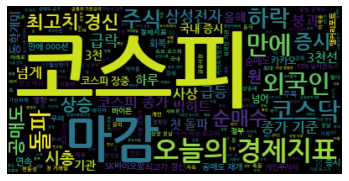

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()

text = " ".join(crawl['title'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [11]:
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()

f = open("stopword_ko.txt", mode='r', encoding="UTF-8") #mode = 'r',     # 선택적 매개변수, 'rt' (읽기용, text mode)가 기본값

stopword_ko_list = []
for word in f:
    stopword_ko_list.append(word.rstrip("\n")) #\n 줄바꿈
    stopword_ko_list.append('[앵커]\r') #\r 커서를 앞으로 이동. 
    stopword_ko_list.append('[기자]\r')
    stopword_ko_list.append('[날씨]')
    stopword_ko_list.append('[속보]')
    stopword_ko_list.append('[영상]')
# [앵커]\r , [기자]\r [날씨] [속보] [영상]

# text = "누리호 발사에 가장 큰 변수는 1단 로켓의 정상 작동 여부였습니다.이 고비는 깨끗하게 성공했는데, 전혀 고려의 대상이 되지 않던 3단 로켓이 복병으로 등장했습니다."
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(stop_words=stopword_ko_list, ngram_range=(1, 1), max_df=1.0)#, min_df=0.2)
cvect = tv.fit_transform(crawl['title'])
vocab_sorted = sorted(tv.vocabulary_.items(), key = lambda x: x[1] if x[1]>5 else 0, reverse = True)
print(vocab_sorted[:20])

[('힘으로', 1104), ('히트칠까', 1103), ('희소식에', 1102), ('흔들', 1101), ('휘청', 1100), ('훌쩍', 1099), ('훈풍에', 1098), ('훈풍', 1097), ('후퇴', 1096), ('후보', 1095), ('효과는', 1094), ('효과', 1093), ('회피해야', 1092), ('회사로', 1091), ('회복할까', 1090), ('회복한', 1089), ('회복', 1088), ('활황', 1087), ('환율은', 1086), ('환율', 1085)]


## 카운트 기반의 단어 표현(Count based word Representation)

### Bag of Words(BoW)

In [6]:
from konlpy.tag import Okt
import re
okt = Okt()

# re.sub('[^a-zA-Z]',' ',text)
token = re.sub("\."," ",con)
token = okt.morphs(token)
print(token)
  
# word2index = {}
# bow = []

['오늘', '의', '경제지표', '입니다', '먼저', '국내', '증시', '부터', '보시겠습니다', '외국인', '과', '기관', '의', '순', '매도', '에', '약세', '를', '보이는', '코스피', '1%', '넘게', '빠지고', '있습니다', '미', '연방', '공개시장', '위원회', ',', 'FOMC', '정례', '회의', '결과', '발표', '를', '하루', '앞두고', '인플레이션', '에', '대한', '부담', '이', '경', '계심', '을', '키운', '모습', '입니다', '코스닥', '지수', '도', '천', '선', '에서', '불안한', '흐름', '보이', '고', '있습니다', '이어서', '미국', '증시', '보시겠습니다', '국내', '증시', '와는', '달리', '사상', '최고', '치', '행진', '을', '이어', '갔습니다', 'S', '&', 'P', '500', ';', '과', '나스닥', '은', '4', '거래', '일', '연속', ',', '다우', '는', '3', '거래', '일', '연속', '신고', '점', '을', '갈아', '치웠습니다', 'FOMC', '의', '자산', '매입', '축소', '예고', ',', '인플레이션', '등', '악재', '에도', '불구', '하고', '기업', '들', '의', '강력한', '실적', '효과', '가', '시장', '을', '견인', '했습니다', '이어서', '환율', '상황', '보시', '죠', '원', '·', '달러', '환율', ',', '이', '시각', '현재', '1,180원', '대에서', '거래', '되고', '있습니다', 'FOMC', '회의', '결과', '발표', '를', '앞두고', '관망', '세', '가', '이어지는', '만큼', '환율', '움직임', '이', '제한', '될', '것', '으로', '보는', '시각', '이', '우세합니다', '위안', '·', '원',

In [7]:
nega = ['매도', '약세', '빠지고', '불안한', '악재', '관망']

In [8]:
vocab = {}
preprocessed_a = []

for a in token:
    # 단어 토큰화
    tokenized_a = word_tokenize(a)
    result = []
    for word in tokenized_a: 
        if word in nega:
            result.append(word)
            if word not in nega:
                vocab[word] = 0 
            vocab[word] += 1
    preprocessed_a.append(result) 
print(preprocessed_a)
print(tokenized_a)

KeyError: '매도'